In [2]:
!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

%matplotlib inline

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Networkx version: 2.3


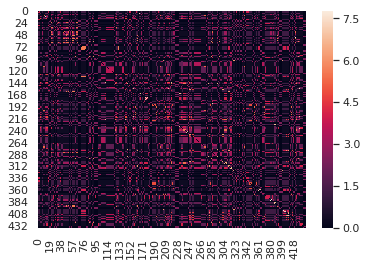

In [3]:
G = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
A = nx.adjacency_matrix(G)
ax = sns.heatmap(A.todense())

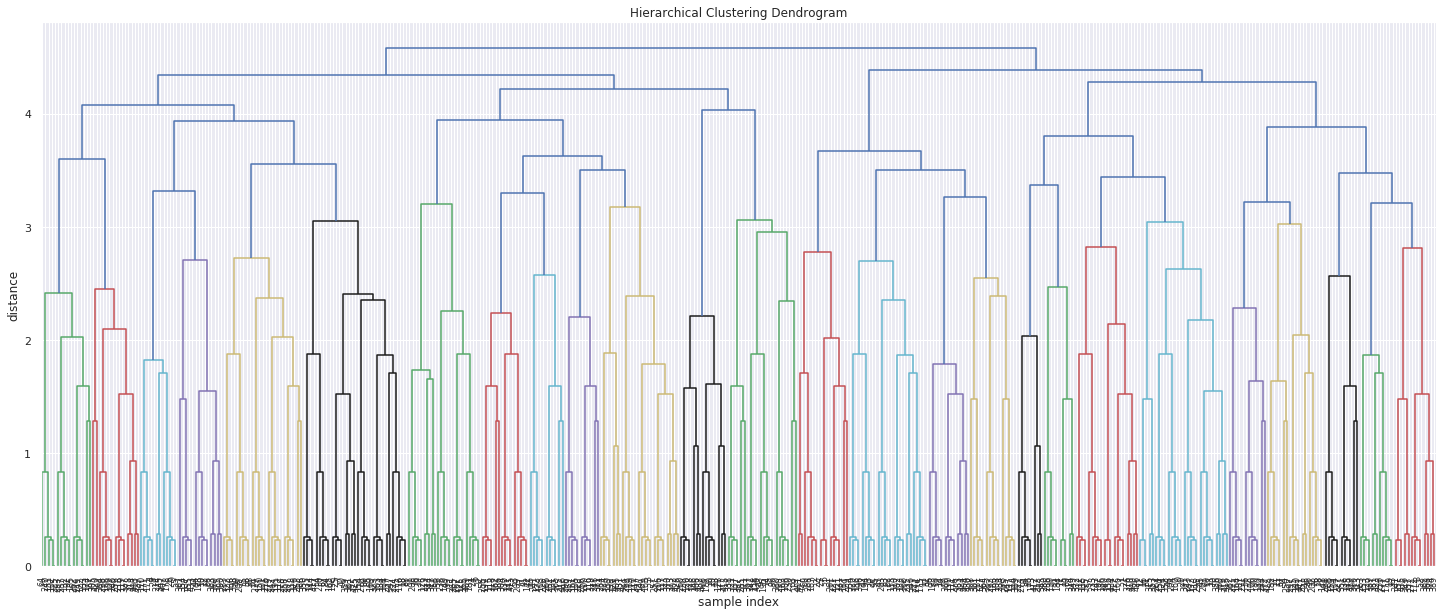

array([[  0.        ,  20.        ,   0.        ,   2.        ],
       [  1.        ,  21.        ,   0.        ,   2.        ],
       [  2.        ,  22.        ,   0.        ,   2.        ],
       ...,
       [867.        , 868.        ,   4.34512936, 237.        ],
       [861.        , 869.        ,   4.38113833, 200.        ],
       [870.        , 871.        ,   4.57776445, 437.        ]])

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

listA = squareform(A.todense())
Z = linkage(listA, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [111]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Construct the graph/hierarchy
d           = { 2: [0, 1], 0: ['c', 'd','e'], 1: ['a', 'b'], 'a': [], 'b': [], 'c': [], 'd': [], 'e': []}
G           = nx.DiGraph(d)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(d[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += d[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last
subtree

{'c': ['c'],
 'a': ['a'],
 'e': ['e'],
 'b': ['b'],
 'd': ['d'],
 2: ['a', 'b', 'c', 'd', 'e'],
 0: ['c', 'd', 'e'],
 1: ['a', 'b']}

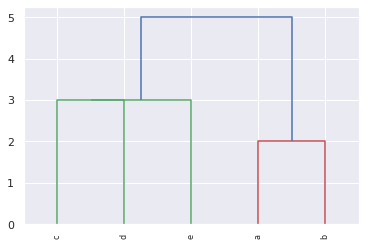

In [126]:
# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z0 = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = d[n]
    if children:
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            #print(y)
            u, v = index[tuple(subtree[x])], index[tuple(subtree[y])]            
            dist = float(len(subtree[n]))
            Z0.append([u, v, dist, len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = sorted(z)
            x = z
            k += 1
# Visualize
if Z0:
    dendrogram(
    Z0,
    labels=leaves,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()

In [122]:
GU = nx.to_undirected(G)
T = nx.minimum_spanning_tree(GU)

In [4]:
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
leaves

NameError: name 'leaves' is not defined

In [5]:
for i, n in enumerate(leaves):
    print(i,n)

NameError: name 'leaves' is not defined

In [11]:
nx.is_directed(G)

False

In [4]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, labels, weighted=True, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = labels #pm.Categorical('z', p=pi, shape=(n,))
        if weighted:
            eta = pm.Normal('eta', mu=10, sd = 1, shape=(k, k))
        else:
            eta = pm.Beta('eta', alpha=1, beta=1, shape=(k, k))
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))]
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices]
        if weighted:
            W = pm.Normal('W', mu=p, sd=1, shape=A_obs[0].shape, observed=A_obs)
        else:
            W = pm.Bernoulli('W', p=p, shape=A_obs[0].shape, observed=A_obs)
    return model

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [42]:
np.random.poisson(1)

1

/home/jovyan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


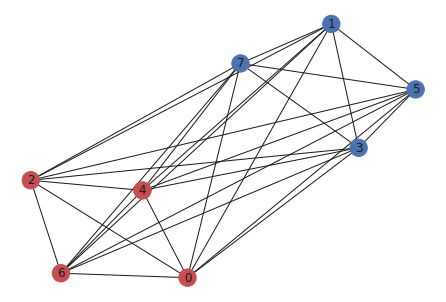

In [5]:
import networkx as nx

# let's generate some data
# there are 2 communities (even and odd nodes)
# intra community edge probability is 0.8
# inter community edge probability is 0.1
Gs = []
p = 100
q = 10
t = 1
n = 8
for i in range(t):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i + 1, n):
            theta = p if (i % 2 == j % 2) else q
            G.add_edge(i, j, weight= np.random.normal(theta, 1, 1))
    Gs.append(G)
    
# show first 5 graphs
pos = nx.spring_layout(Gs[0])
colors = np.array(['r', 'b'])
ground_truth = np.array([i % 2 for i in range(n)])
for i in range(t):
    G = Gs[i]
    nx.draw(G, node_color=colors[ground_truth], with_labels=True, pos=pos)
    plt.show()
    plt.close()

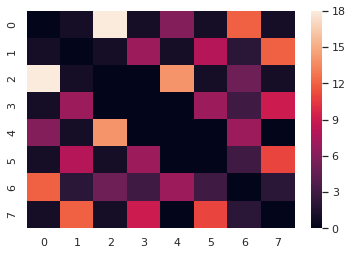

In [79]:
A0 = nx.adjacency_matrix(Gs[0])
ax = sns.heatmap(A0.todense())

In [28]:
k = 2
labels = ground_truth
model = make_pymc3_sbm(Gs, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(500, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:03<00:00, 873.81draws/s] 


In [29]:
k = 3
labels2 = np.array([0, 1, 0, 1, 0, 2, 0, 2])
model = make_pymc3_sbm(Gs, k, labels)
with model as m2:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace2 = pm.sample(500, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:07<00:00, 397.15draws/s]


In [30]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,55.037593,0.298096,0.007125,54.472788,55.622205,1842.665830,0.999528
eta__0_1,10.246463,0.295831,0.007588,9.705084,10.832496,1752.342011,0.999806
eta__0_2,9.976740,0.997316,0.021399,7.911156,11.697343,2188.236983,0.999277
eta__1_0,10.222518,0.389258,0.008767,9.455560,10.949265,1773.826016,0.999043
eta__1_1,55.300124,0.306458,0.007305,54.689460,55.876437,1788.788177,1.000393
eta__1_2,9.968438,0.996798,0.024329,8.252418,12.085041,1732.601783,1.000334
eta__2_0,10.006380,0.971724,0.020960,8.055587,11.760667,1958.068276,0.999664
eta__2_1,10.030012,0.971786,0.025314,8.126933,11.939881,1497.118221,1.001324
eta__2_2,10.005343,0.985822,0.024573,8.103205,11.916872,1671.443952,1.000198


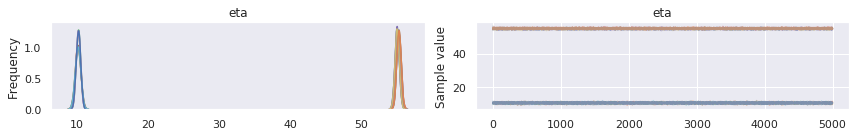

In [8]:
pm.traceplot(trace);

/home/jovyan/.local/lib/python3.6/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jovyan/.local/lib/python3.6/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


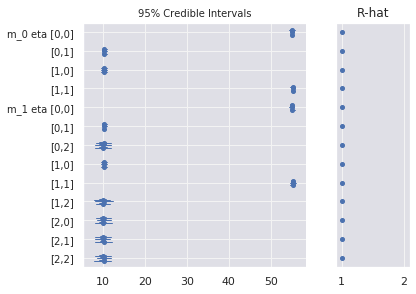

In [31]:
from pymc3 import forestplot, traceplot, plot_posterior
traces = [trace1, trace2]
pm.forestplot(traces);

In [32]:
models = [m1, m2]
m1.name = 'k=2'
m2.name = 'k=3'
comp = pm.compare({m1: trace1, m2: trace2}, method='BB-pseudo-BMA')
comp

/home/jovyan/.local/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k=2,55000.2,4341.41,0,1,8373.79,0,1
k=3,55078.8,4382.03,78.53,0,8384.44,16.59,1


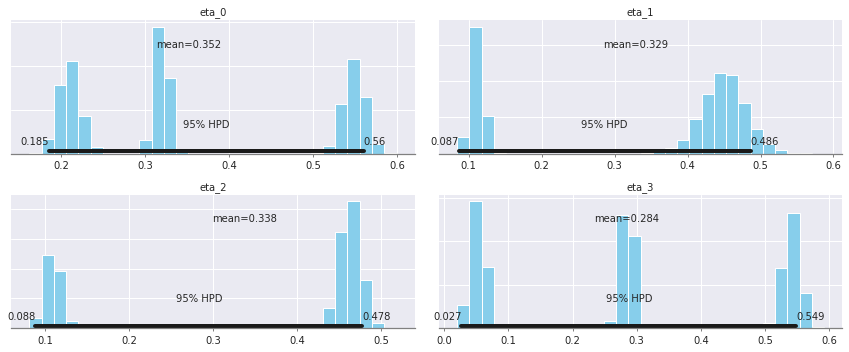

In [87]:
pm.plot_posterior(trace, varnames=['eta']);

In [38]:
weights = comp.weight.sort_index(ascending=True)
weights[0]

1.0

In [41]:
ground_truth

array([0, 1, 0, 1, 0, 1, 0, 1])